# Inicio
El objetivo del proyecto es predecir aquellos clientes con mayor propensión a abrir un mail de marketing sobre la adquisición de tarjetas de crédito por parte de una entidad bancaria
Para eso se utilizarán datos históricos para el entrenamiento
Negocio nos dice que tuvo un equipo de científicos previamente que obtuvo unas métricas que pueden verse a continuación. Sugiere que deberíamos intentar conseguir, al menos, algo similar.

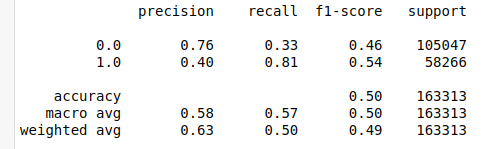

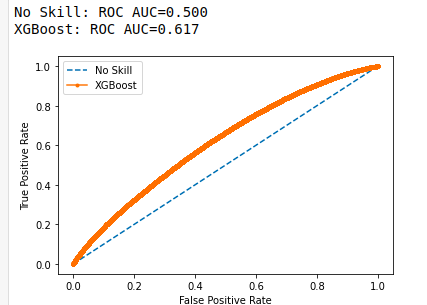

# Carga de dataset

In [51]:
import pandas as pd
df = pd.read_csv('./DatasetModulo2.csv')

In [52]:
pd.set_option('display.max_columns', 50)
print('Shape: ', df.shape)
df.info()

Shape:  (494887, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494887 entries, 0 to 494886
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   FechaSaldos                    494887 non-null  object 
 1   periodo_cli                    494887 non-null  int64  
 2   periodo                        494887 non-null  int64  
 3   cant_productos                 494887 non-null  int64  
 4   cant_PF                        494887 non-null  int64  
 5   cant_TC                        494887 non-null  int64  
 6   cant_PP                        494887 non-null  int64  
 7   FechaUltMovCA                  468164 non-null  object 
 8   cant_seguros                   494887 non-null  int64  
 9   importe_consumos               494887 non-null  int64  
 10  Edad                           494887 non-null  int64  
 11  Sexo                           494887 non-null  object 
 12  SaldoProm

# EDA

## Análisis inicial

In [53]:
df.target.value_counts(normalize=True)

0.0    0.993797
1.0    0.006203
Name: target, dtype: float64

In [54]:
df.target2.value_counts(normalize=True)

0.0    0.643668
1.0    0.356332
Name: target2, dtype: float64

Dada la desproporcionalidad entre 0s y 1s en target, trabajaremos con target2

## Tratamiento de fechas

In [55]:
date_columns = [column for column in df.columns if ('fecha' in column.lower())]
date_columns

['FechaSaldos', 'FechaUltMovCA', 'FechaVinculacion']

In [56]:
date_columns = [column for column in df.columns if ('fecha' in column.lower())]
for date_column in date_columns:
    df[date_column] = pd.to_datetime(df[date_column])
    print(date_column)
    print(df[date_column].describe(), '\n')

FechaSaldos
count                  494887
unique                      3
top       2019-12-06 09:45:00
freq                   247789
first     2019-12-06 09:45:00
last      2020-02-07 14:13:00
Name: FechaSaldos, dtype: object 

FechaUltMovCA
count                  468164
unique                    971
top       2019-12-05 00:00:00
freq                   101996
first     2004-04-19 00:00:00
last      2020-02-06 00:00:00
Name: FechaUltMovCA, dtype: object 

FechaVinculacion
count                  415623
unique                   5134
top       2017-08-07 00:00:00
freq                     7186
first     1990-01-01 00:00:00
last      2020-02-06 00:00:00
Name: FechaVinculacion, dtype: object 



---

## Tratamiento de nulos y valores faltantes

In [57]:
row_has_nan = df.isnull().any(axis=1)
len(df[row_has_nan])/ len(df)

0.3512943358786955

El 35% de las filas tienen al menos un valor nulo

In [58]:
nan_columns = [column for column in df.columns if df[column].isna().any()]

##### Proporcion de nulos  

In [59]:
for column in nan_columns:
    print("{:<40} {:<40}".format(column, sum(df[column].isna())/len(df)))

FechaUltMovCA                            0.05399818544435396                     
FechaVinculacion                         0.16016585604390499                     
SaldoPromedioCAPesos_ant_1               0.0014447742615991126                   
SaldoPromedioCADolares_ant_1             0.0014447742615991126                   
SaldoPromedioCCAcreedor_ant_1            0.0014447742615991126                   
TotalConsumoTD_ant_1                     0.0014447742615991126                   
SaldoPromedioCAPesos_ant_2               0.005787179699608193                    
SaldoPromedioCADolares_ant_2             0.005787179699608193                    
SaldoPromedioCCAcreedor_ant_2            0.005787179699608193                    
TotalConsumoTD_ant_2                     0.005787179699608193                    
score_deuda                              0.17507228922966253                     


#### FechaUltMovCA

In [60]:
df.loc[df.FechaUltMovCA.isna(),'FechaUltMovCA'] = pd.to_datetime('2019-09-20')

#### FechaVinculacion

In [61]:
import datetime
df['antiguedad'] = (df.FechaVinculacion.dt.year - datetime.datetime.now().year)*-1
df.antiguedad.fillna(df.antiguedad.mean(), inplace=True)
df.drop(columns='FechaVinculacion', inplace=True)

#### score_deuda 

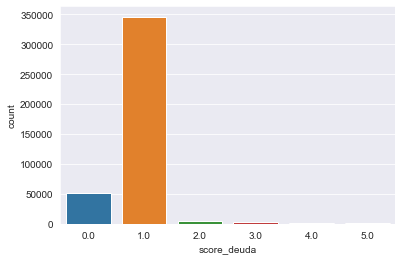

In [62]:
import seaborn as sns
sns.set_style('darkgrid')
sns.countplot(x=df.score_deuda, data=df)

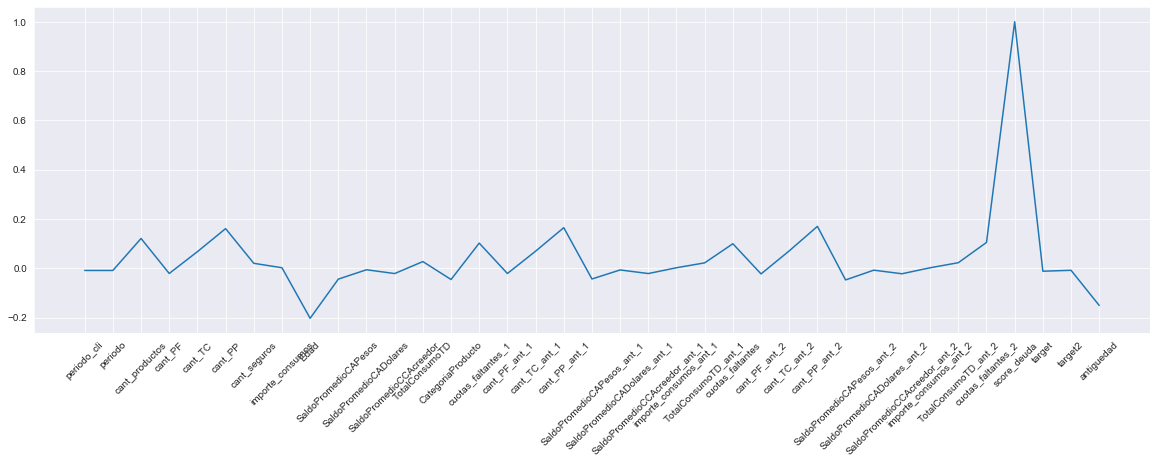

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
plt.plot(df.corr()['score_deuda'].dropna())


No tiene correlación lineal alta con ninguna variable, haremos reemplazo proporcional

In [64]:
import numpy as np
score_deuda_missing = df.score_deuda.isna()
score_deuda_distribution = df.score_deuda.value_counts(normalize=True)
df.loc[score_deuda_missing, 'score_deuda'] = np.random.choice(score_deuda_distribution.index, 
                                                              size=score_deuda_missing.sum(), 
                                                              p=score_deuda_distribution)

In [65]:
nan_columns = [column for column in df.columns if df[column].isna().any()]
for column in nan_columns:
    print(column, df[column].isna().sum())

SaldoPromedioCAPesos_ant_1 715
SaldoPromedioCADolares_ant_1 715
SaldoPromedioCCAcreedor_ant_1 715
TotalConsumoTD_ant_1 715
SaldoPromedioCAPesos_ant_2 2864
SaldoPromedioCADolares_ant_2 2864
SaldoPromedioCCAcreedor_ant_2 2864
TotalConsumoTD_ant_2 2864


#### Sexo

In [66]:
df.Sexo.value_counts(dropna=False)

F    277632
M    215313
       1942
Name: Sexo, dtype: int64

In [67]:
df.Sexo = df.Sexo.str.replace(' ','SinSexo')
df.Sexo.value_counts()

F          277632
M          215313
SinSexo      1942
Name: Sexo, dtype: int64

#### CategoriaProducto

In [68]:
df.CategoriaProducto.value_counts(normalize=True,dropna=False)[:10]

14    0.517437
10    0.208884
12    0.177483
28    0.031868
19    0.020118
18    0.015377
3     0.007640
15    0.004710
9     0.002942
26    0.002762
Name: CategoriaProducto, dtype: float64

In [69]:
to_keep = df.CategoriaProducto.value_counts(normalize=True,dropna=False)[:3].index
df.CategoriaProducto.fillna('OTH',inplace=True)
df.CategoriaProducto = df.CategoriaProducto.apply(lambda x:'OTH' if x not in to_keep else x)
df.CategoriaProducto.value_counts()

14     256073
10     103374
12      87834
OTH     47606
Name: CategoriaProducto, dtype: int64

#### Datos no útiles

In [70]:
df.dropna(inplace=True)
df.drop(columns=[col for col in df.columns if df[col].nunique()==1],inplace=True)
print('periodo == periodo_cli: ', all(df.periodo == df.periodo_cli))

periodo == periodo_cli:  True


In [71]:
df.drop(columns=['FechaSaldos','periodo_cli', 'periodo'],inplace=True)

In [72]:
df.shape

(492016, 37)

## Ingeniería de variables

In [73]:
df['DiasDesdeMov'] = ((df.FechaUltMovCA.dt.date - datetime.datetime(2020,2,10).date())*-1).dt.days

In [74]:
df['FechaUltMovCA_day'] = df['FechaUltMovCA'].dt.day
df['FechaUltMovCA_Dayofweek'] = df['FechaUltMovCA'].dt.dayofweek
df['FechaUltMovCA_month'] = df['FechaUltMovCA'].dt.month
df['FechaUltMovCA_year'] = df['FechaUltMovCA'].dt.year

In [75]:
pivot_table = pd.pivot_table(data=df,
                               index=['FechaUltMovCA_year'],
                               columns=['FechaUltMovCA_month'],
                               aggfunc=['size'],
                              )
pivot_table

size                                                    \
FechaUltMovCA_month      1        2       3       4       5       6        7    
FechaUltMovCA_year                                                              
2004                    NaN      NaN     NaN     2.0     NaN     NaN      NaN   
2005                    NaN      2.0     NaN     NaN     NaN     NaN      NaN   
2006                    NaN      NaN     NaN     2.0     NaN     NaN      NaN   
2007                    NaN      2.0     3.0     NaN     NaN     NaN      NaN   
2008                    2.0      NaN     NaN     2.0     NaN     NaN      NaN   
2009                    NaN      NaN     2.0     NaN     4.0     NaN      1.0   
2010                    NaN      NaN     4.0     1.0     9.0     NaN      2.0   
2011                    NaN      6.0     6.0     2.0     1.0     2.0      5.0   
2012                    2.0      2.0     3.0     1.0     2.0     3.0      3.0   
2013                    6.0      4.0     4.0     7.0     6.0     7.0      7.0   
2014                    6.0      5.0     7.0     4.0     9.0     7.0     11.0   
2015                    5.0      4.0     4.0     5.0     7.0     6.0     10.0   
2016                    5.0      4.0     5.0     6.0     8.0     9.0     13.0   
2017                   18.0     30.0   683.0   396.0   508.0   408.0    496.0   
2018                  640.0    416.0   539.0   633.0   779.0   696.0    662.0   
2019                 5836.0  98624.0  5952.0  6244.0  7224.0  7598.0  12950.0   
2020                 3147.0   4869.0     NaN     NaN     NaN     NaN      NaN   

                                                                  
FechaUltMovCA_month       8        9       10       11        12  
FechaUltMovCA_year                                                
2004                     NaN      NaN     NaN      NaN       NaN  
2005                     NaN      NaN     NaN      NaN       NaN  
2006                     NaN      NaN     NaN      NaN       NaN  
2007                     2.0      2.0     NaN      NaN       NaN  
2008                     NaN      NaN     NaN      1.0       NaN  
2009                     2.0      NaN     NaN      3.0       1.0  
2010                     2.0      8.0    10.0     10.0      17.0  
2011                     5.0      5.0     4.0     10.0       7.0  
2012                     9.0      3.0     4.0      2.0      12.0  
2013                     2.0      3.0     3.0      4.0       4.0  
2014                     6.0      6.0     7.0      2.0      10.0  
2015                     9.0      2.0     4.0      7.0       3.0  
2016                    13.0     12.0     9.0     16.0       9.0  
2017                   546.0    560.0   446.0    440.0     434.0  
2018                   861.0    807.0  1153.0   2819.0    1301.0  
2019                 22993.0  73631.0  1625.0  38590.0  185955.0  
2020                     NaN      NaN     NaN      NaN       NaN

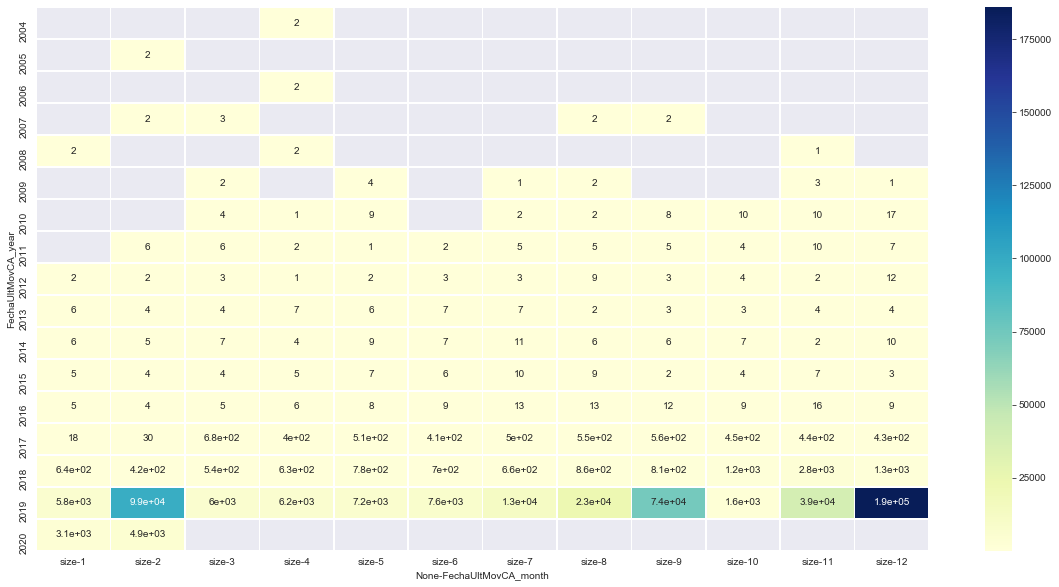

In [76]:
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(pivot_table, annot=True, linewidths=.5, cmap="YlGnBu")

In [77]:
df = df[df['FechaUltMovCA_year']==2019]

In [78]:
df.shape

(467222, 42)

## Variables Categóricas

In [79]:
df.select_dtypes(exclude='number')


,FechaUltMovCA,Sexo,CategoriaProducto
0,2019-12-02,M,12
1,2019-12-04,F,12
2,2019-12-05,F,12
3,2019-12-05,F,12
4,2019-12-05,F,14
...,...,...,...
494876,2019-09-20,SinSexo,OTH
494879,2019-09-27,SinSexo,OTH
494880,2019-07-01,SinSexo,OTH
494883,2019-05-22,SinSexo,OTH


In [80]:
df = pd.concat([df,pd.get_dummies(df.Sexo),pd.get_dummies(df.CategoriaProducto)],axis=1)
df.drop(columns=['Sexo', 'CategoriaProducto'], inplace=True)
df.rename(columns={'Na':'Sin_Sexo'}, inplace=True)

In [81]:
from sklearn.preprocessing import LabelEncoder
df['day_sin'] = np.sin((df.FechaUltMovCA_month)*(2.*np.pi/30))
df['day_cos'] = np.cos((df.FechaUltMovCA_month)*(2.*np.pi/30))
df['dayofweek_sin'] = np.sin((df.FechaUltMovCA_month-1)*(2.*np.pi/7))
df['dayofweek_cos'] = np.cos((df.FechaUltMovCA_month-1)*(2.*np.pi/7))
df['month_sin'] = np.sin((df.FechaUltMovCA_month-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df.FechaUltMovCA_month-1)*(2.*np.pi/12))
df=df.apply(LabelEncoder().fit_transform)

In [83]:
df.columns

Index([               'cant_productos',                       'cant_PF',
                             'cant_TC',                       'cant_PP',
                       'FechaUltMovCA',                  'cant_seguros',
                    'importe_consumos',                          'Edad',
                'SaldoPromedioCAPesos',        'SaldoPromedioCADolares',
             'SaldoPromedioCCAcreedor',                'TotalConsumoTD',
                  'cuotas_faltantes_1',                 'cant_PF_ant_1',
                       'cant_TC_ant_1',                 'cant_PP_ant_1',
          'SaldoPromedioCAPesos_ant_1',  'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1',        'importe_consumos_ant_1',
                'TotalConsumoTD_ant_1',              'cuotas_faltantes',
                       'cant_PF_ant_2',                 'cant_TC_ant_2',
                       'cant_PP_ant_2',    'SaldoPromedioCAPesos_ant_2',
        'SaldoPromedioCADolares_ant_2', 'SaldoProme

# Tratamiento de outliers

In [84]:
columns_with_outliers = [column for column in df.columns if df[column].nunique()>20]
columns_with_outliers.remove('FechaUltMovCA')
columns_with_outliers

['cant_productos',
 'cant_PF',
 'cant_TC',
 'importe_consumos',
 'Edad',
 'SaldoPromedioCAPesos',
 'SaldoPromedioCADolares',
 'SaldoPromedioCCAcreedor',
 'TotalConsumoTD',
 'cuotas_faltantes_1',
 'cant_PF_ant_1',
 'cant_TC_ant_1',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'importe_consumos_ant_1',
 'TotalConsumoTD_ant_1',
 'cuotas_faltantes',
 'cant_PF_ant_2',
 'cant_TC_ant_2',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'importe_consumos_ant_2',
 'TotalConsumoTD_ant_2',
 'cuotas_faltantes_2',
 'antiguedad',
 'DiasDesdeMov',
 'FechaUltMovCA_day']

In [85]:
for column in columns_with_outliers:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df[column] = np.where((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)), df[column].median(), df[column])


In [86]:
df.shape

(467222, 53)

# Análisis de correlación entre columnas

In [ ]:
corr_matrix = df.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))


In [ ]:
sol[:25]

In [ ]:
columns_to_be_dropped = ['FechaUltMovCA_month', 'cant_TC_ant_1','cant_TC_ant_2', 'cant_PP_ant_1', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_1', 
                        'SaldoPromedioCAPesos_ant_2']
df.drop(columns=columns_to_be_dropped, inplace=True)

In [ ]:
df.shape

# Modelado

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = df.sample(frac=0.02)
y = df.target2
columns_to_exclude = ['target2']+[col for col in df.columns if 'Dolares' in str(col)]
X = df[[col for col in df.columns if col not in columns_to_exclude]]

### Scalers

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [ ]:
def scale_test_split(scale_key, X):
    scaler_dict = {1: MinMaxScaler, 2: StandardScaler, 3: RobustScaler}
    scaler = scaler_dict[scale_key]()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled)

    X = X_scaled.copy()
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    return X_train, X_test, y_train, y_test

### Sampling

In [ ]:
from sklearn.utils import resample

In [ ]:
# Elegir escalador entre 1 y tres y ver performance
X_train, X_test, y_train, y_test = scale_test_split(3, X)
train_data = pd.concat([X_train.reset_index(),y_train.reset_index()],axis=1)

In [ ]:
negative = train_data[train_data['target2']==0]
positive = train_data[train_data['target2']==1]
pos_upsampled = resample(positive,
     replace=True, # sample with replacement
     n_samples=len(negative), # match number in majority class
     random_state=27) # reproducible results# combine majority and upsampled minority
upsampled = pd.concat([negative, pos_upsampled])# check new class counts
upsampled['target2'].value_counts()

In [ ]:
from sklearn.utils import shuffle
upsampled = shuffle(upsampled)
y_train = upsampled['target2']
X_train = upsampled.drop(columns=['target2', 'index'])

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
def calculate_roc(testy,lr_probs):
    ns_probs = [0 for _ in range(len(testy))]
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

### Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rfc.fit(X_train, y_train)
y_preds = rfc.predict(X_test)

In [45]:
y_preds = rfc.predict(X_test)

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1530
           1       0.43      0.58      0.49       821

    accuracy                           0.58      2351
   macro avg       0.58      0.58      0.57      2351
weighted avg       0.62      0.58      0.59      2351



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.584


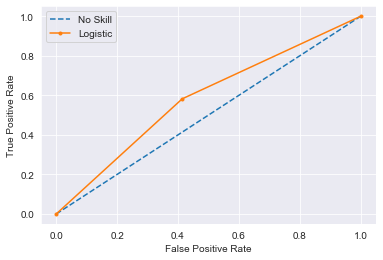

In [47]:
calculate_roc(y_test,y_preds)

### Regresión Logística

In [54]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l2',solver='lbfgs',C=0.1,max_iter=10000)
logreg.fit(X_train,y_train)
y_preds = logreg.predict(X_test)

In [55]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.71      0.60      0.65      1507
           1       0.43      0.55      0.48       829

    accuracy                           0.58      2336
   macro avg       0.57      0.57      0.57      2336
weighted avg       0.61      0.58      0.59      2336



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.574


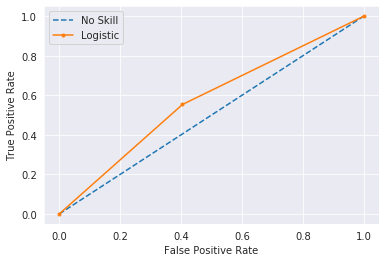

In [56]:
calculate_roc(y_test,y_preds)

### Decision tree

In [57]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth=6)
tree.fit(X_train,y_train)
preds = tree.predict(X_test)
y_preds = tree.predict(X_test)

In [58]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.71      0.61      0.65      1507
           1       0.43      0.54      0.48       829

    accuracy                           0.59      2336
   macro avg       0.57      0.58      0.57      2336
weighted avg       0.61      0.59      0.59      2336



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.576


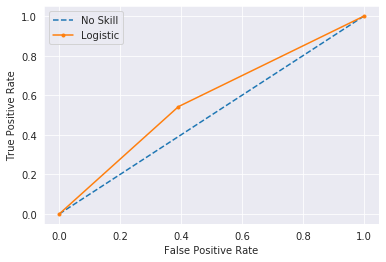

In [59]:
calculate_roc(y_test,y_preds)

### SVM

In [60]:
from sklearn.svm import SVC
model = SVC(probability=False, kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63      1507
           1       0.42      0.55      0.47       829

    accuracy                           0.57      2336
   macro avg       0.56      0.56      0.55      2336
weighted avg       0.60      0.57      0.57      2336



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.563


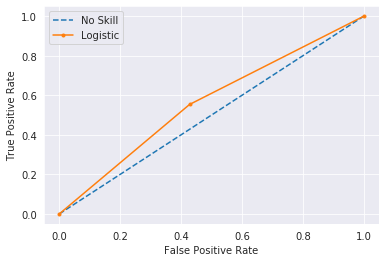

In [62]:
calculate_roc(y_test, y_pred)

### KNN

In [63]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.67      0.67      1507
           1       0.38      0.36      0.37       829

    accuracy                           0.56      2336
   macro avg       0.52      0.52      0.52      2336
weighted avg       0.56      0.56      0.56      2336



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.518


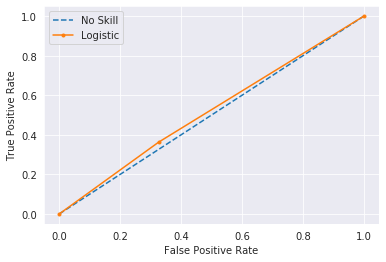

In [64]:
calculate_roc(y_test, y_pred)